In [14]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math

In [15]:
#sum function
def theSum(aList):
    s = 0 
    for x in aList:
       if x > 0:
           s += x
    return s

def theCount(aList,value):
    c = 0 
    for x in aList:
       if x == value:
           c += 1
    return c

def randDemand(ad,sd):
    d = -1
    while d<0 or d>25:
        d = int(round((0.5 + np.random.lognormal(ad,sd)),0))
    
    return d

In [133]:
ad = 4.97 #average daily demand
sd = 5.36
Q = 64 # Order Quantity (Full truck load) for Slow Shipping
Qn = 35 #capacidad normal
Qf = 12 #capacidad fast
ss = int(round(ad * 2,0)) #Security Stock
lt_s = 5 #lead time for slow shipping
R =  lt_s*ad + ss #re-order point
lt_n = 3 #lead time for normal shipping
lt_f = 1 #lead time for fast shipping

dw_p = [.7, .2, .1] #probability for delivery windows of 1, 3 and 5 days, respectively
results = []
results2 = []
total_results =[]
for instances in range(100):
    inventory = Q + ss #initialize inventory
    T = -1 #initialize lead time for slow shipping, it is -1 when there is no slow incoming shipping
    po = [[0 for p in range(1)] for t in range(2)] #Number of incoming orders using normal and/or fast shipping
    po_a = [[-1 for p in range(1)] for t in range(2)] # of days remaining for incoming orders to arrive using normal and/or fast shipping
    orders = [0 for t in range(6)] #orders to be delivered before day t
    em = [0 for i in range(3)] #emissions per type of shippment 
    con_t = [0 for i in range(3)] # contador times type of shippment ordered
    con_o = [0 for i in range(3)] # contador units  type of shippment ordered
    total_demand = 0
    np.random.seed(instances)
    
    #for days in range(30):
    for days in range(87):
       
    #validate incoming orders
        #print('day', days,'t=',T,'inventory', inventory)
        if T > 0: #slow orders update delivery date and inventory
            T -= 1
            if T == 0:
                print(inventory)
                inventory += Q
                print('llego pedido', inventory)
                T = -1
        
        #update delivery dates normal and fast shipping
        for o in range(len(po[0])): #normal incoming shippings
            if po[0][o] > 0:
                po_a[0][o] -= 1        
        if po[1][0] > 0: #fast incoming shippings
            po_a[1][0] -= 1
#         if po[1][0] < 0:
#             #print(instances,days)
                
        #update inventory and lists  for normal and fast shipping      
        if po_a[0][0] == 0: #normal shipping
            inventory += po[0][0]
            if len(po[0]) == 1:
                po[0][0] = 0
                po_a[0][0] = -1 # -1 means there is no incoming order placed
            else:
                for o in range(len(po[0])-1):
                    #print(po[0], o, o+1, len(po[0]))
                    po[0][o] = po[0][o+1]
                    po_a[0][o] = po_a[0][o+1]
                    #print('orders',po[0])
                #print('ordenes pendientes antes de borrar',po[0], po_a[0], len(po[0]))
                po[0].pop() #pop remove last element of the list
                po_a[0].pop()
                    #print('lat orders',po[0])
                
        
        if po_a[1][0] == 0: #fast shipping
            inventory += po[1][0]
            po[1][0] = 0
            po_a[1][0] = -1 # -1 means there is no fast order placed
 
        
    #generate demand and allocate it to diferent delivery windows
        #demand = max(int(np.random.normal(ad,5.03)),0)
        demand = randDemand(ad,sd)
        orders[1] += int(round(demand*dw_p[0],0))
        orders[3] += int(round(demand*dw_p[1],0))
        orders[5] += int(round(demand*dw_p[2],0))
        total_demand += int(demand)
        #print(orders)
        #print ('demand', orders[1], orders[3], orders[5])
        
        #inventory balance
        inventory -= orders[0] #remove from inventory orders to be delivery today
        
        for t in range(5): #send also pending orders if there is stock
            if inventory > 0:
                if inventory > orders[1+t]:
                    inventory -= orders[1+t]
                    orders[1+t] = 0
                else:
                    inventory = 0
                    orders[1+t] -= inventory
        
    #place new incomming shippings according to demand, inventory and/or phantom inventory
        p_inventory = 0 #phantom inventory
        p_demand = 0 # pending demand
        
        #slow shipping - evaluation of extisting order
        #print('inventory=',inventory, 'R', R, T)
        if inventory <= R and T == -1: 
            #print('inventario antes de pedir pedido',inventory)
            T = lt_s
            em[0] += 2.621*61.9*0.276
            #(61.9 km is the distance) and CE = 2.621 CO2/liter
            con_t[0] += 1
            con_o[0] += Q
        
        
        #normal shipping - evaluation of next 3 days         
        if T < 3 and T>-1: #slow shipping phatom inventory
            p_inventory += Q
        
        for o in range(len(po[0])): #normal shipping phantom inventory
            if po_a[0][o]<3:
                p_inventory += po[0][o]
        
        for d in range(3):
            p_demand += orders[d+1] 
        if inventory + p_inventory - p_demand - 3*ad*(dw_p[0]+dw_p[1]) <= ss: # balance includeing expecting demand in 2 days
            if po_a[0][0] == -1:
                po[0][0] = int(round(ss - (inventory + p_inventory - p_demand - 3*ad),0))
                #print(po[0][0], ss, inventory, p_inventory, p_demand, 3*ad)
                po_a[0][0] = 3
                p_inventory += po[0][0]
                em[1] += 2.621*61.9*0.276*math.ceil(po[0][0]/Qn)*(0.227 + 0.049*po[0][0]/(Q*math.ceil(po[0][0]/Qn)))
                con_t[1] += 1
                con_o[1] += po[0][0]
            else:
                order_size = int(round(ss - (inventory + p_inventory - p_demand - 3*ad),0))
                po[0].append(order_size)
                po_a[0].append(3)
                p_inventory += order_size
                em[1] += 2.621*61.9*0.276*math.ceil(order_size/Qn)*(0.227 + 0.049*order_size/(Q*math.ceil(order_size/Qn)))
                con_t[1] += 1
                con_o[1] += order_size
        
        #fast shipping - evaluation of next day         
        p_inventory = 0 #phantom inventory
        p_demand = orders[1] # pending demand
        
        if T == 1: 
            p_inventory += Q
        
        for o in range(len(po[0])): #normal shipping phantom inventory
            if po_a[0][o] == 1:
                p_inventory += po[0][o]
        if inventory + p_inventory - p_demand - ad*dw_p[0] <= ss: # balance includeing expecting demand to be delivered next day
            po_a[1][0] = 1
            order_size = int(round(ss - (inventory + p_inventory - p_demand - ad),0))
            po[1][0] = order_size
            em[2] += 2.621*61.9*0.276*math.ceil(order_size/Qf)*(0.227 + 0.049*order_size/(Q*math.ceil(order_size/Qf)))
            con_t[2] += 1
            con_o[2] += order_size
       
    
        #export results
        results.append([instances+1,days+1,demand, theSum(orders), inventory, Q*(T==5), theSum(po[0]), theCount(po_a[0],3), theSum(po[1]), theCount(po_a[1],1)])
        results2.append([instances+1,days+1,demand, orders, inventory, T, po[0], po_a[0], po[1], po_a[1]])
        
        #pending demand update for next day
        for t in range(5):
            orders[t] = orders[t+1]
        orders[5] = 0
        #print('orders normal=',po[0], po_a[0])
    total_results.append([instances, total_demand,em[0]+em[1]+em[2], con_t[0],con_o[0],em[0], con_t[1],con_o[1],em[1],con_t[2],con_o[2],em[2]])       
        

12
llego pedido 76
16
llego pedido 80
20
llego pedido 84
6
llego pedido 70
17
llego pedido 81
27
llego pedido 91
14
llego pedido 78
22
llego pedido 86
26
llego pedido 90
16
llego pedido 80
26
llego pedido 90
14
llego pedido 78
13
llego pedido 77
25
llego pedido 89
14
llego pedido 78
14
llego pedido 78
28
llego pedido 92
22
llego pedido 86
22
llego pedido 86
27
llego pedido 91
12
llego pedido 76
30
llego pedido 94
14
llego pedido 78
2
llego pedido 66
21
llego pedido 85
22
llego pedido 86
16
llego pedido 80
11
llego pedido 75
4
llego pedido 68
1
llego pedido 65
0
llego pedido 64
17
llego pedido 81
23
llego pedido 87
19
llego pedido 83
10
llego pedido 74
22
llego pedido 86
14
llego pedido 78
1
llego pedido 65
14
llego pedido 78
0
llego pedido 64
22
llego pedido 86
14
llego pedido 78
29
llego pedido 93
1
llego pedido 65
9
llego pedido 73
19
llego pedido 83
30
llego pedido 94
3
llego pedido 67
18
llego pedido 82
5
llego pedido 69
14
llego pedido 78
14
llego pedido 78
14
llego pedido 78
26
l

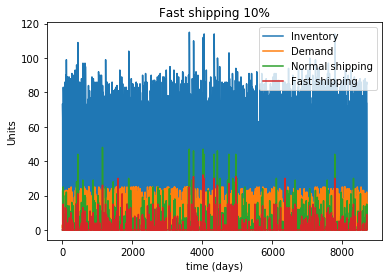

In [134]:
df = pd.DataFrame(results, columns =['Instance', 'Day', 'Demand', 'Orders', 'Inventory', 'T', 'Normal Orders', 'Normal days', 'Fast orders', 'Fast days'])
df.to_excel("Results Experiments v2.xlsx",index=False)
plt.plot(df['Inventory'],label="Inventory")
plt.plot(df['Demand'], label="Demand")
#plt.plot(df['T'], label="Q-FTL")
plt.plot(df['Normal Orders'], label="Normal shipping")
plt.plot(df['Fast orders'], label="Fast shipping")
plt.ylabel('Units')
plt.xlabel('time (days)')
plt.title ('Fast shipping 10%')
plt.legend()
plt.show()

In [135]:
np.mean(df['Fast orders']/df['Demand'])

0.024219554423027534

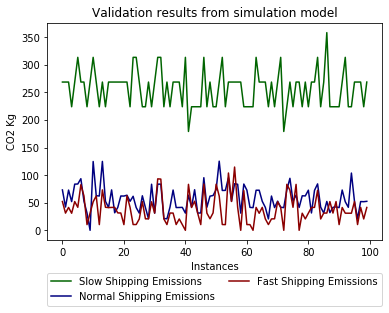

In [136]:
df = pd.DataFrame(total_results, columns =['Instance', 'Demand', 'Total Emissions', 'Slow Times', 'Slow Units', 'Slow Emissions', 'Normal Times', 'Normal Units', 'Normal Emissions', 'Fast Times', 'Fast Units', 'Fast Emissions'])
df.to_excel("Results Total v5- Base.xlsx",index=False)
#plt.plot(df['Demand'],label="Demand")
plt.plot(df['Slow Emissions'], label="Slow Shipping Emissions", color='darkgreen')
#plt.plot(df['T'], label="Q-FTL")
plt.plot(df['Normal Emissions'], label="Normal Shipping Emissions", color='navy')
plt.plot(df['Fast Emissions'], label="Fast Shipping Emissions", color='darkred')
plt.ylabel('CO2 Kg')
plt.xlabel('Instances')
plt.title ('Validation results from simulation model')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend()
plt.show()

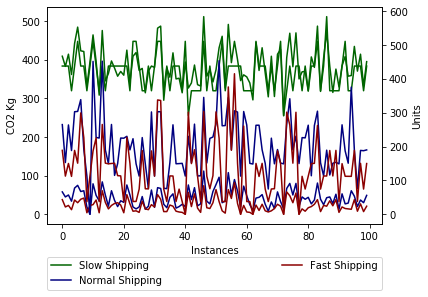

In [126]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df['Slow Units'], label="Slow Shipping", color='darkgreen')
ax2.plot(df['Demand'], label="Slow Shipping", color='darkgreen')

ax1.plot(df['Normal Units'], label="Normal Shipping", color='navy')
ax2.plot(df['Normal Emissions'], label="Normal Shipping", color='navy')

ax1.plot(df['Fast Units'], label="Fast Shipping", color='darkred')
ax2.plot(df['Fast Emissions'], label="Fast Shipping", color='darkred')

#plt.plot(df['T'], label="Q-FTL")
# plt.plot(df['Normal Units'], label="Normal Shipping Emissions", color='navy')
# plt.plot(df['Fast Units'], label="Fast Shipping Emissions", color='darkred')
# plt.ylabel('CO2 Kg')
# plt.xlabel('Instances')
# plt.title ('Validation results from simulation model')
#ax2.legend(loc=0)
ax1.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
#ax1.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)


#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax1.set_xlabel('Instances')
ax1.set_ylabel('CO2 Kg')
ax2.set_ylabel('Units')

#plt.legend()
plt.show()

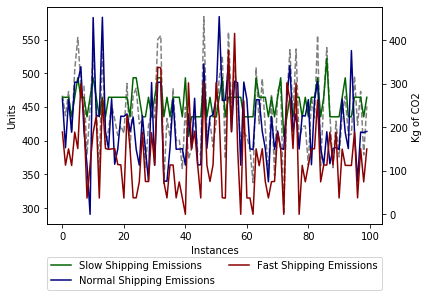

In [127]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(df['Slow Emissions'], label="Slow Shipping Emissions", color='darkgreen')
ax1.plot(df['Demand'], label="Demand", color='gray', linestyle = 'dashed')

#ax1.plot(df['Normal Units'], label="Normal Shipping", color='navy')
ax2.plot(df['Normal Emissions'], label="Normal Shipping Emissions", color='navy')

#ax1.plot(df['Fast Units'], label="Fast Shipping", color='darkred')
ax2.plot(df['Fast Emissions'], label="Fast Shipping Emissions", color='darkred')

#plt.plot(df['T'], label="Q-FTL")
# plt.plot(df['Normal Units'], label="Normal Shipping Emissions", color='navy')
# plt.plot(df['Fast Units'], label="Fast Shipping Emissions", color='darkred')
# plt.ylabel('CO2 Kg')
# plt.xlabel('Instances')
# plt.title ('Validation results from simulation model')
#ax2.legend(loc=0)
#ax1.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
ax2.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=0, ncol=2, mode="expand", borderaxespad=0)
#ax2.legend(loc=0)

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax1.set_xlabel('Instances')
ax1.set_ylabel('Units')
ax2.set_ylabel('Kg of CO2 ')

#plt.legend()
plt.savefig('figure7b.jpg',dpi=3000,bbox_inches='tight')
plt.show()

In [112]:
np.mean(df['Total Emissions'])

352.222690066082

In [113]:
np.mean(df['Demand'])

438.6

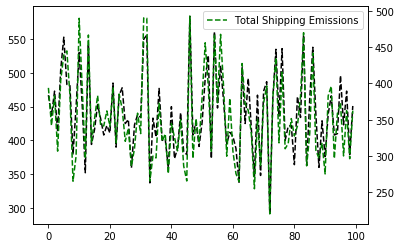

In [61]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df['Demand'],label="Demand", color = 'k', linestyle='dashed')
ax2.plot(df['Total Emissions'], label="Total Shipping Emissions", color='green', linestyle='dashed')
plt.legend()
plt.show()

No handles with labels found to put in legend.


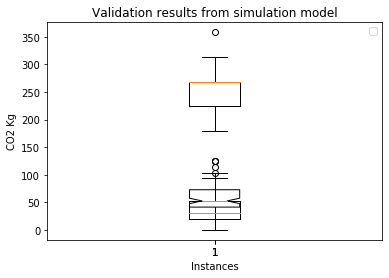

In [40]:
df = pd.DataFrame(total_results, columns =['Instance', 'Demand', 'Total Emissions', 'Slow Times', 'Slow Units', 'Slow Emissions', 'Normal Times', 'Normal Units', 'Normal Emissions', 'Fast Times', 'Fast Units', 'Fast Emissions'])
df.to_excel("Results Total v5- Base.xlsx",index=False)
#plt.boxplot(df['Demand'])
plt.boxplot(df['Slow Emissions'])
#plt.plot(df['T'], label="Q-FTL")
plt.boxplot(df['Normal Emissions'], 'green')
plt.boxplot(df['Fast Emissions'])
plt.ylabel('CO2 Kg')
plt.xlabel('Instances')
plt.title ('Validation results from simulation model')
plt.legend()
plt.show()

In [26]:
np.mean(df['Fast Emissions'])

0.0

In [ ]:
df = pd.DataFrame(total_results, columns =['Instance', 'Demand', 'Total Emissions', 'Slow Times', 'Slow Units', 'Slow Emissions', 'Normal Times', 'Normal Units', 'Normal Emissions', 'Fast Times', 'Fast Units', 'Fast Emissions'])
df.to_excel("Results Total v4.xlsx",index=False)
plt.plot(df['Demand'],label="Demand")
plt.plot(df['Slow Units'], label="Slow Units")
#plt.plot(df['T'], label="Q-FTL")
plt.plot(df['Normal Units'], label="Normal Units")
plt.plot(df['Fast Units'], label="Fast Units ")
plt.ylabel('Units')
plt.xlabel('Instances')
plt.title ('Fast shipping 10%')
plt.legend()
plt.show()

In [24]:
np.mean(df['Total Emissions'])

352.222690066082

In [93]:
df

,Instance,Demand,Slow Times,Slow Units,Slow Emissions,Normal Times,Normal Units,Normal Emissions,Fast Times,Fast Units,Fast Emissions
0,0,867,10,640,447.782124,18,169,216.214797,16,130,21.749417
1,1,868,10,640,447.782124,19,163,208.538532,17,114,10.235020
2,2,810,10,640,447.782124,17,122,156.084055,16,89,2.558755
3,3,840,10,640,447.782124,19,159,203.421022,15,99,15.352530
4,4,878,9,576,403.003912,20,168,214.935420,16,129,8.955642
...,...,...,...,...,...,...,...,...,...,...,...
95,95,842,10,640,447.782124,19,149,190.627247,20,119,8.955642
96,96,800,9,576,403.003912,14,132,168.877830,15,113,14.073152
97,97,791,10,640,447.782124,17,127,162.480942,15,82,2.558755
98,98,778,9,576,403.003912,17,142,181.671605,15,97,10.235020


In [148]:
df

,Instance,Day,Demand,Orders,Inventory,T,Normal Orders,Normal days,Fast orders,Fast days
0,1,1,5.030000,0,70,0,0,0,0,0
1,1,2,11.350896,0,59,0,0,0,0,0
2,1,3,5.030000,0,55,0,0,0,0,0
3,1,4,11.284859,0,44,0,0,0,0,0
4,1,5,9.271477,0,36,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
82,1,83,13.103995,0,3,0,25,1,12,1
83,1,84,9.524262,0,7,0,25,1,0,0
84,1,85,12.229282,0,59,0,25,1,0,0
85,1,86,9.787413,0,51,0,25,1,0,0


In [103]:
results2[8][6]


[4, 4, 4]

In [101]:
len(results)

650

650

In [69]:
results[]

[0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0]

In [41]:
a = [[0 for p in range(1)] for t in range(2)]
a

[[0], [0]]

[[0], [0]]

In [44]:
a[1][0]=3
a

[[0], [3]]

[[0], [3]]

In [49]:
max(a)

[3, 4]

[3, 4]

In [71]:
a[1].append(4)
a

[[0], [3, 4]]

[[0], [3, 4]]

In [72]:
sum(a[1])

7

7

In [57]:
a[1].pop()
a

[[0], [3]]

[[0], [3]]

In [56]:
remove(a[1])

NameError: name 'remove' is not defined

NameError: name 'remove' is not defined

In [54]:
len(a[0])

1

1

In [17]:
demand = int(np.random.normal(average_demand,4.97))

In [14]:
int(demand)

5

5

In [15]:
np.random.lognormal(4.97,5.36)

780582.2881458111

780582.2881458111

In [20]:
demand=(0.5 + np.random.lognormal(4.97,5.36,1000))
demand

array([3.63827176e+02, 5.32625564e-01, 1.60764591e+05, 4.80324202e+03,
       2.91562368e+03, 6.64239649e-01, 6.46226207e+03, 1.35903838e+05,
       2.40399559e+00, 7.01763387e+05, 7.36368577e+00, 6.78583190e+01,
       1.64816876e+01, 8.42661759e+00, 1.70974553e+01, 1.80962120e+06,
       1.61683580e+07, 9.92477578e+05, 6.70825189e+02, 6.25659920e+02,
       7.41266918e+03, 4.49607902e+05, 8.80687508e+00, 1.65785300e+01,
       4.11136146e+06, 9.06443557e+00, 5.15017519e+00, 1.29657391e+05,
       5.61403083e-01, 9.97066925e-01, 6.97401643e+01, 1.05849778e+03,
       1.60343005e+03, 6.18473593e+00, 8.13995515e-01, 2.02675280e+05,
       3.04453934e+00, 2.10529142e+01, 2.73211537e+00, 1.36666876e+05,
       6.35388103e+02, 1.23946991e+00, 2.46618256e+03, 1.60551505e+05,
       6.12187472e+03, 6.60535708e+02, 4.28376464e+04, 1.95488933e+00,
       1.54888565e+05, 3.45180424e+03, 1.13073094e+00, 1.25693318e+06,
       3.06764888e+05, 3.63387422e+01, 1.28272811e+04, 4.53866107e+03,
      

In [ ]:
import matplotlib.pyplot as plt 

plt.hist(demand, bins=1000)
plt.show()

In [22]:
max(demand)

22393918745.31264